In [1]:
import nltk 
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import torch
import torch.nn as nn
import torch.autograd as autograd
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to
[nltk_data]     /home/bhanupratap/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Synthetic Train Data
----------------

In [2]:
train_data = [['The patient had major bleeding when admitted yesterday','Relevant','Yes'],
             ['The patient was admitted on [DATE] and resides at [PLACE]','Non-Relevant','False'],
             ['There was no bleeding observed in the patient since the prescription of medication.','Relevant','No'],
             ['Since the surgery, minor clotting was observed in patients stomach.','Relevant','DK']]

In [3]:
# Tokenize the sentences with the help of nltk word tokenizer
train_data = [[word_tokenize(x[0]), x[1], x[2]] for x in train_data]

In [4]:
def prepare_dicts(data_):
    word_to_ix = {}
    class_to_ix = {}
    relevance_to_ix = {}
    for each_ in data_:
        tokens = list(each_[0])
        for each_token in tokens:
            if(each_token not in word_to_ix):
                word_to_ix[each_token] = len(word_to_ix)
    word_to_ix['<START>'] = len(word_to_ix)
    word_to_ix['<END>'] = len(word_to_ix)
    word_to_ix['<UNK>'] = len(word_to_ix)
    word_to_ix['<PAD>'] = len(word_to_ix)
    
    relevance_to_ix['Non-Relevant'] = 0
    relevance_to_ix['Relevant'] = 1
    
    class_to_ix['Yes'] = 0
    class_to_ix['No'] = 1
    class_to_ix['DK'] = 2
    class_to_ix['False'] = 3
    to_ix = {}
    to_ix['word2ix'] = word_to_ix
    to_ix['class2ix'] = class_to_ix
    to_ix['relevance2ix'] = relevance_to_ix
    return to_ix

In [5]:
# Create all the required vocab dictionaries
to_ix = prepare_dicts(train_data)

# Functions below to batchify the datapoints
-----------------------------------

In [6]:
def batchify(all_datapoints, to_ix):
    main_sents = []
    main_scores = []
    main_relevances = []

    for each_datapoint in all_datapoints:
        main_sents.append(each_datapoint[0])
        main_relevances.append(to_ix['relevance2ix'][each_datapoint[1]])
        main_scores.append(to_ix['class2ix'][each_datapoint[2]])
    sorted_sents, sorted_lens, descend_indices = get_sequence_doc(main_sents, to_ix, LIMIT_LEN=150)
    sorted_scores = []
    sorted_relevances = []
    sorted_contexts = []
    sorted_rel_weights = []
    sorted_sc_weights = []
    sorted_main_docs = []
    
    for ind in descend_indices:
        sorted_scores.append(main_scores[ind])
        sorted_relevances.append(main_relevances[ind])
        
    dict_ = {'sents':sorted_sents, 
            'lens':sorted_lens,
            'scores':sorted_scores,
            'relevances':sorted_relevances}
    return dict_

def get_sequence_doc(sentences, to_ix, LIMIT_LEN = 150):
    max_len = 0
    batch_sents = []
    for each_sentence in sentences:
        batch_sent = []
        for x in each_sentence:
            if(x not in to_ix['word2ix']):
                batch_sent.append(to_ix['word2ix']['<UNK>'])
            else:
                batch_sent.append(to_ix['word2ix'][x])
        if(len(batch_sent)>max_len):
            max_len = len(batch_sent)
        batch_sents.append(batch_sent)
    if(max_len>LIMIT_LEN):
        max_len = LIMIT_LEN
    all_lens = [len(x[:max_len]) for x in batch_sents]
    all_lens = [x+2 for x in all_lens]
    batch_sents = [[to_ix['word2ix']['<START>']]+batch_sents[ind][:max_len]+[to_ix['word2ix']['<END>']]+[to_ix['word2ix']['<PAD>'] for x in range(max_len-len(batch_sents[ind]))] for ind in range(len(batch_sents))]

    descend_indices = list(np.argsort(all_lens))
    descend_indices.reverse()
    sorted_sents = []
    sorted_lens = []
    for ind in descend_indices:
        sorted_sents.append(batch_sents[ind])
        sorted_lens.append(all_lens[ind])
    return sorted_sents, sorted_lens, descend_indices

# Model 
- LSTM/Bi-LSTM encoder with dot attention for multi-class classification
----------------------

In [7]:
class NaranjoTut(nn.Module):
    def __init__(self, config):
        super(NaranjoTut, self).__init__()
        '''
            hidden_dim: To define the hidden dimensions of the LSTM encoder
            ans_size: Number of answer classes
            relevance_size: Number of relevance classes
            vocab_size: Size of our token vocabulary
            embed_dim: Dimension of vocab embeddings
            bilstm_flag: Whether the LSTM encoder is bidirectional or not
            layers: Number of LSTM or BiLSTM layer in the encoder
            dropout: The dropout coefficient for our LSTM layers
        '''
        self.config = config
        self.hidden_dim = config['hidden_dim']
        self.ans_size = config['ans_size']
        self.relevance_size = config['relevance_size']
        self.vocab_size = config['vocab_size']
        self.embed_dim = config['embed_dim']
        self.hidden2relevance = nn.Linear(config['hidden_dim'], config['relevance_size'])
        self.hidden2ans = nn.Linear(config['hidden_dim'], config['ans_size'])
        
        self.bilstm_flag = config['bilstm_flag']
        self.layers=config['layers']
        self.dropout=config['dropout']
        
        # defining the word embeddings
        self.word_embeddings = nn.Embedding(self.vocab_size, self.embed_dim)
        
        # Defining the LSTM encoder
        if(self.bilstm_flag):
            self.lstm_word = nn.LSTM(self.embed_dim, int(self.hidden_dim/2), num_layers = self.layers,
                                bidirectional=True, batch_first=True, dropout=self.dropout)
        else:
            self.lstm_word = nn.LSTM(self.embed_dim, self.hidden_dim, num_layers = self.layers,
                                bidirectional=False, batch_first=True, dropout=self.dropout)
        
        self.attn_relevance = DotAttentionLayer(self.hidden_dim)
    
    def init_hidden(self, bilstm_flag, batch_size, layers, hidden_dim):
        # num_layes, minibatch size, hidden_dim
        if(bilstm_flag):
            return (autograd.Variable(torch.FloatTensor(layers*2,
                                                             batch_size,
                                                             int(hidden_dim/2)).fill_(0)),
                   autograd.Variable(torch.FloatTensor(layers*2,
                                                            batch_size,
                                                            int(hidden_dim/2)).fill_(0)))
        else:
            return (autograd.Variable(torch.FloatTensor(layers,
                                                             batch_size,
                                                             hidden_dim).fill_(0)),
                   autograd.Variable(torch.FloatTensor(layers,
                                                            batch_size,
                                                            hidden_dim).fill_(0)))
    
    def forward(self, sent_inds, sent_lens):
        # Getting the embeddings
        embeds = self.word_embeddings(sent_inds)
        
        # Pack the whole batch and initialize the hidden and cell states for the LSTM encoder
        packed = pack_padded_sequence(embeds, batch_lens, batch_first = True)
        self.hidden_vals = self.init_hidden(self.bilstm_flag, embeds.shape[0], self.layers, self.hidden_dim)
        
        # Getting the hidden states from the encoder for each of the token
        packed_output, self.hidden_vals = self.lstm_word(packed, self.hidden_vals)
        lstm_out = pad_packed_sequence(packed_output, batch_first=True)[0]
        
        # Getting sequence representation by doing weighted summation
        pad_op = self.attn_relevance((lstm_out,batch_lens))
        
        # Softmax probs for relevance classification
        tag_space_rel = self.hidden2relevance(pad_op)
        tag_space_rel = F.log_softmax(tag_space_rel,dim=1) 
        
        # Softmax probs for answer classification
        tag_space_ans = self.hidden2ans(pad_op)
        tag_space_ans = F.log_softmax(tag_space_ans, dim=1) 
        
        return tag_space_rel, tag_space_ans
        
class DotAttentionLayer(nn.Module):
    def __init__(self, hidden_size):
        super(DotAttentionLayer, self).__init__()
        self.hidden_size = hidden_size
        self.W = nn.Linear(hidden_size, 1, bias=False)

    def forward(self, input):
        """
        input: (unpacked_padded_output: batch_size x seq_len x hidden_size, lengths: batch_size)
        """
        inputs, lengths = input
        batch_size, max_len, _ = inputs.size()
        flat_input = inputs.contiguous().view(-1, self.hidden_size)
        logits = self.W(flat_input).view(batch_size, max_len)
        alphas = F.softmax(logits, dim=1)

        # computing mask
        idxes = torch.arange(0, max_len, out=torch.LongTensor(max_len)).unsqueeze(0)
        mask = autograd.Variable((idxes<lengths.unsqueeze(1)).float())
        alphas = alphas * mask
        
        # renormalize
        alphas = alphas / torch.sum(alphas, 1).view(-1, 1)
        output = torch.bmm(alphas.unsqueeze(1), inputs).squeeze(1)
        return output

In [8]:
model_config = {
    'hidden_dim' : 400,
    'bilstm_flag': True,
    'ans_size' : len(to_ix['class2ix']),
    'relevance_size' : len(to_ix['relevance2ix']),
    'vocab_size' : len(to_ix['word2ix']),
    'embed_dim' : 180, 
    'layers':2, 
    'dropout':0.1, 
    'lr':0.01,
    'weight_decay':1e-6,
    'batch_size':2,
    'alpha':0.5,
    'model_name': 'AMIA_tutorial_'
}

# Initializing Model, Loss function and Optimizer
---------------------------------------------------

In [9]:
model = NaranjoTut(model_config)
loss_function = nn.NLLLoss(reduce=False)
optimizer = optim.SGD(model.parameters(), 
                           lr=model_config['lr'], 
                           weight_decay=model_config['weight_decay'])

/home/bhanupratap/py3/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


## Batchifying 2 datapoints together
--------------------------

In [10]:
train_loss_list = []

pred_rel = []
actual_rel = []

pred_sc = []
actual_sc = []

train_loss = 0

batch = batchify(train_data[0:2], to_ix)
batch_sents = autograd.Variable(torch.LongTensor(batch['sents']))
batch_lens = autograd.Variable(torch.LongTensor(batch['lens']))

## Passing them through the model
---------------------------------

In [11]:
score_rel, score_ans = model(batch_sents, batch_lens)

## Getting the relevance and answer predictions
------------

In [12]:
actual_relevance_score = autograd.Variable(torch.LongTensor(batch['relevances'])) 
val, inds = torch.max(score_rel, dim=1)
pred_rel+=inds.tolist()
actual_rel+=actual_relevance_score.tolist()

actual_sc_score = autograd.Variable(torch.LongTensor(batch['scores']))
val, inds = torch.max(score_ans, dim=1)
pred_sc+=inds.tolist()
actual_sc+=actual_sc_score.tolist()

In [13]:
print("Actual Relevances", actual_rel)
print("Predicted Relevances", pred_rel)
print('--'*10)
print("Actual Answers", actual_sc)
print("Predicted Answers", pred_sc)

Actual Relevances [0, 1]
Predicted Relevances [1, 1]
--------------------
Actual Answers [3, 0]
Predicted Answers [0, 3]


## Calculating Relevance and Answer Loss
---------------------------------

In [14]:
relevance_loss = loss_function(score_rel, actual_relevance_score)
sc_loss = loss_function(score_ans, actual_sc_score)

## Multi-task Loss
loss = model_config['alpha']*torch.sum(relevance_loss)+(1-model_config['alpha'])*torch.sum(sc_loss)
train_loss+=loss.item()

In [15]:
loss.backward()
optimizer.step()

# Training the model
------------------------------

In [17]:
train_loss_list = []
train_sc_loss_list = []
for epoch in tqdm(range(50)):
    pred_rel = []
    actual_rel = []

    pred_sc = []
    actual_sc = []

    train_loss = 0
    tot_sc_loss = 0
    for ind in range(0,len(train_data), model_config['batch_size']):
        batch = batchify(train_data[ind:ind+model_config['batch_size']], to_ix)
        batch_sents = autograd.Variable(torch.LongTensor(batch['sents']))
        batch_lens = autograd.Variable(torch.LongTensor(batch['lens']))
        
        score_rel, score_ans = model(batch_sents, batch_lens)

        actual_relevance_score = autograd.Variable(torch.LongTensor(batch['relevances'])) 
        val, inds = torch.max(score_rel, dim=1)
        pred_rel+=inds.tolist()
        actual_rel+=actual_relevance_score.tolist()

        actual_sc_score = autograd.Variable(torch.LongTensor(batch['scores']))
        val, inds = torch.max(score_ans, dim=1)
        pred_sc+=inds.tolist()
        actual_sc+=actual_sc_score.tolist()

        relevance_loss = loss_function(score_rel, actual_relevance_score)
        sc_loss = loss_function(score_ans, actual_sc_score)

        loss = model_config['alpha']*torch.sum(relevance_loss)+(1-model_config['alpha'])*torch.sum(sc_loss)
        train_loss+=loss.item()
        tot_sc_loss+=torch.sum(sc_loss).item()

        loss.backward()
        optimizer.step()
    train_loss_list.append(train_loss)
    train_sc_loss_list.append(tot_sc_loss)

In [18]:
print("Actual Relevances", actual_rel)
print("Predicted Relevances", pred_rel)
print('--'*10)
print("Actual Answers", actual_sc)
print("Predicted Answers", pred_sc)

Actual Relevances [0, 1, 1, 1]
Predicted Relevances [0, 1, 1, 1]
--------------------
Actual Answers [3, 0, 1, 2]
Predicted Answers [3, 0, 1, 2]


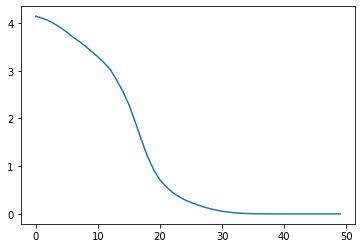

In [19]:
plt.plot(train_loss_list)

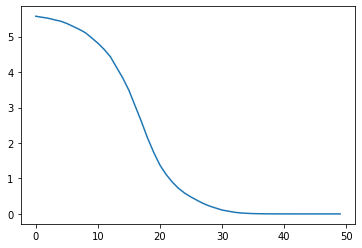

In [20]:
plt.plot(train_sc_loss_list)